In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDClassifier
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem.snowball import SnowballStemmer
from matplotlib import pyplot as plt
import pandas as pd
import gensim
from sklearn import metrics
import seaborn as sns

In [36]:
# Some constants will be used to preprocess the datasets
stemmer = SnowballStemmer("english")
stop = stopwords.words('english')
stop.append('@')
pd.set_option('display.max_colwidth', -1)

In [ ]:
pip install nltk
pip install gensim

In [18]:
# Return Accuracy, Precision, Recall, F-Score
def print_metrics(pred,y_test):
    acc= np.mean(pred == y_test)*100
    f_score= f1_score(y_test, pred,average='weighted')*100
    p = precision_score(y_test, pred,average='weighted')*100
    r = recall_score(y_test, pred,average='weighted',labels=np.unique(pred))*100
    print("Accuracy is",acc)
    print("Precision is",p)
    print("Recall is",r)
    print("F1-Score is",f_score)
    return acc, p, r, f_score

In [95]:
## Accuracy, Precision, Recall

# More Advanced Function that helps a lot in evaluating the algorithms on our datasets
def print_results(y_test,predicted,predicted_prob):
    classes = np.unique(y_test)
    accuracy = metrics.accuracy_score(y_test, predicted)
    auc = metrics.roc_auc_score(y_test, predicted_prob, 
                                multi_class="ovr")
    print("Accuracy:",  round(accuracy,2))
    print("Area Under The Curve:", round(auc,2))
    print("Detail:")
    print(metrics.classification_report(y_test, predicted))
    
    ## Plot confusion matrix
    cm = metrics.confusion_matrix(y_test, predicted)
    make_confusion_matrix(cf=cm,figsize=(8,5))

    
# https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
# Draws the confusion matrix in a very nice way
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title="Confusion Matrix"):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

# Training on 911 Videos

In [59]:
df_911 = pd.read_excel('All911Comments.xlsx',index=False).dropna()

#Removing '\n' and '\t' with ' '
df_911['comment'] =  df_911['comment'].str.replace('\n',' ')
df_911['comment'] =  df_911['comment'].str.replace('\t',' ')

## Trying Without any Stemming and with Stopwords using MultinomialNB

In [60]:
X = df_911['comment']
Y = df_911['stance']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=10)
X_train = X_train.reset_index(drop=True).tolist()
X_test  = X_test.reset_index(drop=True).tolist()
y_train = y_train.reset_index(drop=True).tolist()
y_test  = y_test.reset_index(drop=True).tolist()

Accuracy: 0.8
Area Under The Curve: 0.92
Detail:
              precision    recall  f1-score   support

          -1       0.68      0.56      0.62     12411
           0       0.79      0.80      0.79     33650
           1       0.84      0.88      0.86     41102

    accuracy                           0.80     87163
   macro avg       0.77      0.75      0.76     87163
weighted avg       0.80      0.80      0.80     87163



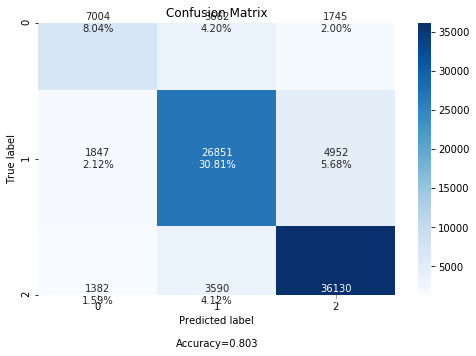

In [96]:
clf_1 = Pipeline([('tfidf', TfidfVectorizer(max_df=0.1, min_df= 0,strip_accents= 'unicode',lowercase=True)),
                 ('NB_clf',MultinomialNB(alpha=0.1))])

clf_1 = clf_1.fit(X_train, y_train)

# Prints the vocab getting from TfidfVectorizer
# print('vocabulary: ',clf_1['tfidf'].vocabulary_)

pred = clf_1.predict(X_test)
print_metrics(pred,y_test)
pred_proba = clf_1.predict_proba(X_test)
print_results(y_test,pred,pred_proba)

## Trying With Stemming Only with MultinomialNB

In [97]:
# Stemming
df_911_Stemmed = df_911
df_911_Stemmed['comment'] = df_911_Stemmed['comment'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

X = df_911_Stemmed['comment']
Y = df_911_Stemmed['stance']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=10)
X_train = X_train.reset_index(drop=True).tolist()
X_test  = X_test.reset_index(drop=True).tolist()
y_train = y_train.reset_index(drop=True).tolist()
y_test  = y_test.reset_index(drop=True).tolist()

Accuracy: 0.8
Area Under The Curve: 0.92
Detail:
              precision    recall  f1-score   support

          -1       0.69      0.55      0.61     12411
           0       0.78      0.80      0.79     33650
           1       0.84      0.87      0.86     41102

    accuracy                           0.80     87163
   macro avg       0.77      0.74      0.75     87163
weighted avg       0.79      0.80      0.80     87163



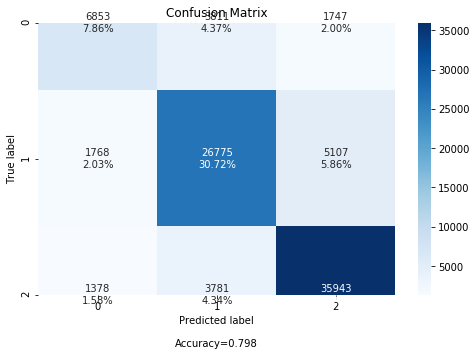

In [98]:
clf_1 = clf_1.fit(X_train, y_train)
pred = clf_1.predict(X_test)
pred_proba = clf_1.predict_proba(X_test)
print_results(y_test,pred,pred_proba)

## Trying With Stemming and Removing Stopwords with MultinomialNB 

In [99]:
#Removing rows that have nan as comment - ALREADY removed while reading the csv

df_911_Stemmed_Stopwords = df_911

# Stemming
df_911_Stemmed_Stopwords['comment'] = df_911_Stemmed_Stopwords['comment'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

# Removing Stopwords
df_911_Stemmed_Stopwords['comment'] = df_911_Stemmed_Stopwords['comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop) and not word.isdigit()]))

X = df_911_Stemmed_Stopwords['comment']
Y = df_911_Stemmed_Stopwords['stance']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=10)
X_train = X_train.reset_index(drop=True).tolist()
X_test  = X_test.reset_index(drop=True).tolist()
y_train = y_train.reset_index(drop=True).tolist()
y_test  = y_test.reset_index(drop=True).tolist()

Accuracy: 0.8
Area Under The Curve: 0.92
Detail:
              precision    recall  f1-score   support

          -1       0.68      0.56      0.61     12411
           0       0.78      0.79      0.79     33650
           1       0.84      0.87      0.86     41102

    accuracy                           0.80     87163
   macro avg       0.77      0.74      0.75     87163
weighted avg       0.79      0.80      0.79     87163



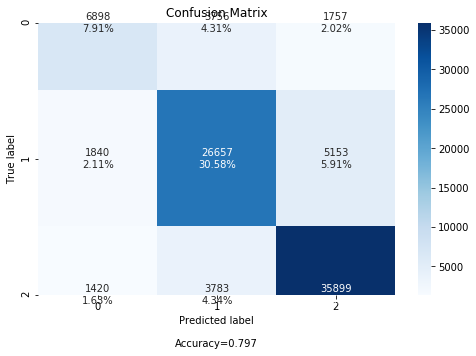

In [100]:
clf_1 = clf_1.fit(X_train, y_train)
pred = clf_1.predict(X_test)
pred_proba = clf_1.predict_proba(X_test)
print_results(y_test,pred,pred_proba)

In [ ]:
## This cell was previously used to choose the best parameter

## --------------- GRID SEARCH FOR PARAMETER TUNING -----------------------

clf_1 = Pipeline([('tfidf', TfidfVectorizer()),
                 ('NB_clf',MultinomialNB())])


parameters = {'NB_clf__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], 
              'tfidf__max_df':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
              'tfidf__min_df':[0]}

grid_gearch = GridSearchCV(clf_1, parameters, n_jobs=-1)


grid_gearch = grid_gearch.fit(X_train, y_train)

print(grid_gearch.best_score_, grid_gearch.best_params_)


#Output I got for grid search: 
# 0.7946835229092032 {'NB_clf__alpha': 0.1, 'tfidf__max_df': 0.1, 'tfidf__min_df': 0}

## Trying Without any Stemming and with Stopwords using SGDClassifier

In [101]:
X = df_911['comment']
Y = df_911['stance']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=10)
X_train = X_train.reset_index(drop=True).tolist()
X_test  = X_test.reset_index(drop=True).tolist()
y_train = y_train.reset_index(drop=True).tolist()
y_test  = y_test.reset_index(drop=True).tolist()

Accuracy: 0.78
Area Under The Curve: 0.92
Detail:
              precision    recall  f1-score   support

          -1       0.74      0.41      0.53     12411
           0       0.74      0.83      0.78     33650
           1       0.84      0.86      0.85     41102

    accuracy                           0.78     87163
   macro avg       0.77      0.70      0.72     87163
weighted avg       0.78      0.78      0.78     87163



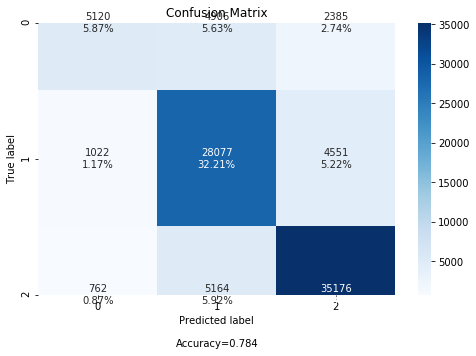

In [102]:
clf_2 = Pipeline([('tfidf', TfidfVectorizer(max_df=0.3, min_df= 1e-05,strip_accents= 'unicode',lowercase=True)),
                      ('clf-SGD', SGDClassifier(loss='hinge', penalty='l2',alpha=0.0001,max_iter=1500))])

clf_2 = clf_2.fit(X=X_train,y=y_train)
pred = clf_2.predict(X_test)
pred_proba = clf_2.predict_proba(X_test)
print_results(y_test,pred,pred_proba)

## Trying With Stemming and Removing Stopwords with SGDClassifier 

In [104]:

#Removing rows that have nan as comment - ALREADY removed while reading the csv

df_911_Stemmed_Stopwords = df_911

# Stemming
df_911_Stemmed_Stopwords['comment'] = df_911_Stemmed_Stopwords['comment'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

# Removing Stopwords
df_911_Stemmed_Stopwords['comment'] = df_911_Stemmed_Stopwords['comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop) and not word.isdigit()]))


In [105]:

X = df_911_Stemmed_Stopwords['comment']
Y = df_911_Stemmed_Stopwords['stance']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=10)
X_train = X_train.reset_index(drop=True).tolist()
X_test  = X_test.reset_index(drop=True).tolist()
y_train = y_train.reset_index(drop=True).tolist()
y_test  = y_test.reset_index(drop=True).tolist()



In [107]:
clf_2 = Pipeline([('tfidf', TfidfVectorizer(max_df=0.1, min_df= 1e-05,strip_accents= 'unicode',lowercase=True)),
                      ('clf-SGD', SGDClassifier(loss='hinge', penalty='l2',alpha=0.0001,max_iter=1500))])

clf_2 = clf_2.fit(X=X_train,y=y_train)
pred = clf_2.predict(X_test)
pred_proba = clf_2.predict_proba(X_test)
print_metrics(pred,y_test)

Accuracy is 78.40368046074596
Precision is 78.32123876550308
Recall is 78.40368046074596
F1-Score is 77.56776570278316


(78.40368046074596, 78.32123876550308, 78.40368046074596, 77.56776570278316)

In [ ]:
## This cell was previously used to choose the best parameter

## --------------- GRID SEARCH FOR PARAMETER TUNING -----------------------


clf_2 = Pipeline([('tfidf', TfidfVectorizer()),
                 ('SGD_clf',SGDClassifier( penalty='l2'))])

parameters = {'SGD_clf__alpha':[1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
              'SGD_clf__loss': ['log','hinge']}

grid_gearch_2 = GridSearchCV(clf_2, parameters, n_jobs=-1,scoring='accuracy')


grid_gearch_2 = grid_gearch_2.fit(X_train, y_train)

print(grid_gearch_2.best_score_, grid_gearch_2.best_params_)

# The best params I got for GRID Search CV is:

# 0.7818082171638323 {'SGD_clf__alpha': 0.0001, 'SGD_clf__loss': 'hinge'}

# Training on Moon Landing Comments

In [108]:
df_moon = pd.read_excel('AllMoonLandingComments.xlsx',index=False).dropna()

#Removing '\n' and '\t' with ' '
df_moon['comment'] =  df_moon['comment'].str.replace('\n',' ')
df_moon['comment'] =  df_moon['comment'].str.replace('\t',' ')

In [109]:
X = df_moon['comment']
Y = df_moon['stance']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=10)
X_train = X_train.reset_index(drop=True).tolist()
X_test  = X_test.reset_index(drop=True).tolist()
y_train = y_train.reset_index(drop=True).tolist()
y_test  = y_test.reset_index(drop=True).tolist()

Accuracy: 0.76
Area Under The Curve: 0.74
Detail:
              precision    recall  f1-score   support

          -1       0.76      0.99      0.86     24157
           0       0.49      0.06      0.10      2572
           1       0.75      0.12      0.21      5585

    accuracy                           0.76     32314
   macro avg       0.67      0.39      0.39     32314
weighted avg       0.74      0.76      0.69     32314



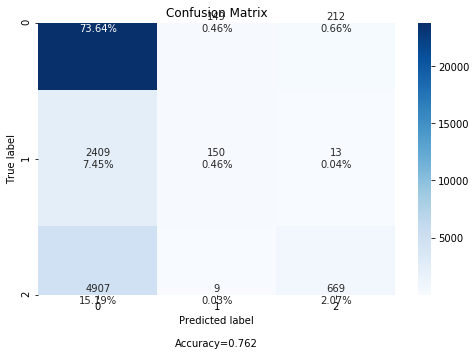

In [110]:
clf_1 = Pipeline([('tfidf', TfidfVectorizer(max_df=0.1, min_df= 0,strip_accents= 'unicode',lowercase=True)),
                 ('NB_clf',MultinomialNB(alpha=0.1))])

clf_1 = clf_1.fit(X_train, y_train)

# Prints the vocab getting from TfidfVectorizer
# print('vocabulary: ',clf_1['tfidf'].vocabulary_)

pred = clf_1.predict(X_test)
pred_proba = clf_1.predict_proba(X_test)
print_results(y_test,pred,pred_proba)

In [112]:
clf_2 = Pipeline([('tfidf', TfidfVectorizer(max_df=0.1, min_df= 1e-05,strip_accents= 'unicode',lowercase=True)),
                      ('clf-SGD', SGDClassifier(loss='hinge', penalty='l2',alpha=0.0001,max_iter=1500))])

clf_2 = clf_2.fit(X=X_train,y=y_train)
pred = clf_2.predict(X_test)
#probability estimates are not available for loss='hinge'
print_metrics(pred,y_test)

Accuracy is 75.72259701677292
Precision is 80.49781768373175
Recall is 75.72259701677292
F1-Score is 66.25606148241756


(75.72259701677292, 80.49781768373175, 75.72259701677292, 66.25606148241756)

In [113]:
#Removing rows that have nan as comment - ALREADY removed while reading the csv

df_moon_Stemmed_Stopwords = df_moon

# Stemming
df_moon_Stemmed_Stopwords['comment'] = df_moon_Stemmed_Stopwords['comment'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

# Removing Stopwords
df_moon_Stemmed_Stopwords['comment'] = df_moon_Stemmed_Stopwords['comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop) and not word.isdigit()]))

X = df_moon_Stemmed_Stopwords['comment']
Y = df_moon_Stemmed_Stopwords['stance']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=10)
X_train = X_train.reset_index(drop=True).tolist()
X_test  = X_test.reset_index(drop=True).tolist()
y_train = y_train.reset_index(drop=True).tolist()
y_test  = y_test.reset_index(drop=True).tolist()

Accuracy: 0.76
Area Under The Curve: 0.73
Detail:
              precision    recall  f1-score   support

          -1       0.76      0.98      0.86     24157
           0       0.49      0.06      0.10      2572
           1       0.73      0.12      0.20      5585

    accuracy                           0.76     32314
   macro avg       0.66      0.39      0.39     32314
weighted avg       0.74      0.76      0.69     32314



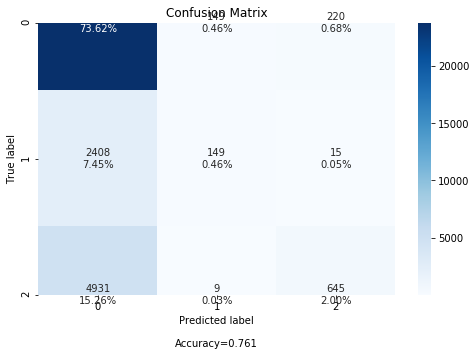

In [114]:
clf_1 = Pipeline([('tfidf', TfidfVectorizer(max_df=0.1, min_df= 0,strip_accents= 'unicode',lowercase=True)),
                 ('NB_clf',MultinomialNB(alpha=0.1))])


clf_1 = clf_1.fit(X_train, y_train)
pred = clf_1.predict(X_test)
pred_proba = clf_1.predict_proba(X_test)
#probability estimates are not available for loss='hinge'
print_results(y_test,pred,pred_proba)

In [115]:
clf_2 = Pipeline([('tfidf', TfidfVectorizer(max_df=0.1, min_df= 1e-05,strip_accents= 'unicode',lowercase=True)),
                      ('clf-sgd', SGDClassifier(loss='hinge', penalty='l2',alpha=0.0001,max_iter=1500))])

clf_2 = clf_2.fit(X=X_train,y=y_train)
pred = clf_2.predict(X_test)
#probability estimates are not available for loss='hinge'

print_metrics(pred,y_test)

Accuracy is 75.70093457943925
Precision is 80.46289652071563
Recall is 75.70093457943925
F1-Score is 66.21143457752353


(75.70093457943925, 80.46289652071563, 75.70093457943925, 66.21143457752353)

# Train on Vaccine Videos

In [116]:
df_vaccine = pd.read_excel('AllVaccinesComments.xlsx',index=False).dropna()

#Removing '\n' and '\t' with ' '
df_vaccine['comment'] =  df_vaccine['comment'].str.replace('\n',' ')
df_vaccine['comment'] =  df_vaccine['comment'].str.replace('\t',' ')

## Trying all results without stemming and without removing stopwords

In [117]:
X = df_vaccine['comment']
Y = df_vaccine['stance']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=10)
X_train = X_train.reset_index(drop=True).tolist()
X_test  = X_test.reset_index(drop=True).tolist()
y_train = y_train.reset_index(drop=True).tolist()
y_test  = y_test.reset_index(drop=True).tolist()

Accuracy: 0.79
Area Under The Curve: 0.82
Detail:
              precision    recall  f1-score   support

          -1       0.79      0.98      0.87     53164
           0       0.82      0.26      0.40     14055
           1       0.72      0.07      0.14      4090

    accuracy                           0.79     71309
   macro avg       0.78      0.44      0.47     71309
weighted avg       0.79      0.79      0.74     71309



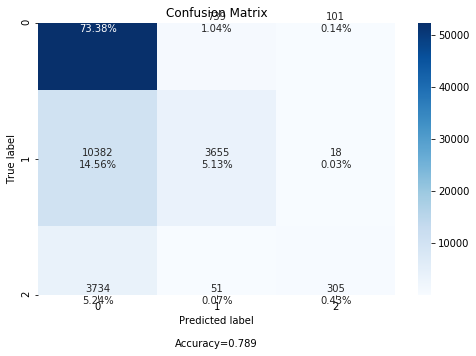

In [118]:
clf_1 = Pipeline([('tfidf', TfidfVectorizer(max_df=0.1, min_df= 0,strip_accents= 'unicode',lowercase=True)),
                 ('NB_clf',MultinomialNB(alpha=0.1))])


clf_1 = clf_1.fit(X_train, y_train)
pred = clf_1.predict(X_test)
pred_proba = clf_1.predict_proba(X_test)
print_results(y_test,pred,pred_proba)

In [ ]:
clf_2 = Pipeline([('tfidf', TfidfVectorizer(max_df=0.1, min_df= 1e-05,strip_accents= 'unicode',lowercase=True)),
                      ('clf-SGD', SGDClassifier(loss='hinge', penalty='l2',alpha=0.0001,max_iter=1000))])

clf_2 = clf_2.fit(X=X_train,y=y_train)
pred = clf_2.predict(X_test)
#probability estimates are not available for loss='hinge'

print_metrics(pred,y_test)

## Trying all results with stemming and with removing stopwords

In [119]:
#Removing rows that have nan as comment - ALREADY removed while reading the csv

df_vaccine_Stemmed_Stopwords = df_vaccine

# Stemming
df_vaccine_Stemmed_Stopwords['comment'] = df_vaccine_Stemmed_Stopwords['comment'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

# Removing Stopwords
df_vaccine_Stemmed_Stopwords['comment'] = df_vaccine_Stemmed_Stopwords['comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop) and not word.isdigit()]))

X = df_vaccine_Stemmed_Stopwords['comment']
Y = df_vaccine_Stemmed_Stopwords['stance']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=10)
X_train = X_train.reset_index(drop=True).tolist()
X_test  = X_test.reset_index(drop=True).tolist()
y_train = y_train.reset_index(drop=True).tolist()
y_test  = y_test.reset_index(drop=True).tolist()

Accuracy: 0.79
Area Under The Curve: 0.81
Detail:
              precision    recall  f1-score   support

          -1       0.79      0.98      0.87     53164
           0       0.82      0.25      0.39     14055
           1       0.74      0.08      0.14      4090

    accuracy                           0.79     71309
   macro avg       0.78      0.44      0.47     71309
weighted avg       0.79      0.79      0.74     71309



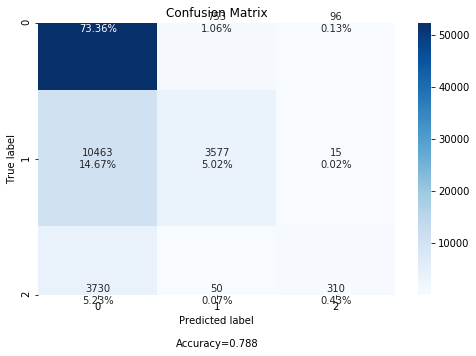

In [120]:
clf_1 = Pipeline([('tfidf', TfidfVectorizer(max_df=0.1, min_df= 0,strip_accents= 'unicode',lowercase=True)),
                 ('NB_clf',MultinomialNB(alpha=0.1))])


clf_1 = clf_1.fit(X_train, y_train)
pred = clf_1.predict(X_test)
pred_proba = clf_1.predict_proba(X_test)
print_results(y_test,pred,pred_proba)

In [121]:
clf_2 = Pipeline([('tfidf', TfidfVectorizer(max_df=0.1, min_df= 1e-05,strip_accents= 'unicode',lowercase=True)),
                      ('clf-SGD', SGDClassifier(loss='hinge', penalty='l2',alpha=0.0001,max_iter=1000))])

clf_2 = clf_2.fit(X=X_train,y=y_train)
pred = clf_2.predict(X_test)
print_metrics(pred,y_test)

Accuracy is 77.51195501269125
Precision is 79.79674322773663
Recall is 77.51195501269125
F1-Score is 70.63402870881863


(77.51195501269125, 79.79674322773663, 77.51195501269125, 70.63402870881863)

# Training on Flat Earth

In [122]:
df_flat = pd.read_excel('AllFlatEarthComments.xlsx',index=False).dropna()

#Removing '\n' and '\t' with ' '
df_flat['comment'] =  df_flat['comment'].str.replace('\n',' ')
df_flat['comment'] =  df_flat['comment'].str.replace('\t',' ')

X = df_flat['comment']
Y = df_flat['stance']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=10)
X_train = X_train.reset_index(drop=True).tolist()
X_test  = X_test.reset_index(drop=True).tolist()
y_train = y_train.reset_index(drop=True).tolist()
y_test  = y_test.reset_index(drop=True).tolist()

Accuracy: 0.82
Area Under The Curve: 0.76
Detail:
              precision    recall  f1-score   support

          -1       0.82      0.99      0.90    126588
           0       0.64      0.06      0.11     22501
           1       0.83      0.24      0.37      8089

    accuracy                           0.82    157178
   macro avg       0.76      0.43      0.46    157178
weighted avg       0.80      0.82      0.76    157178



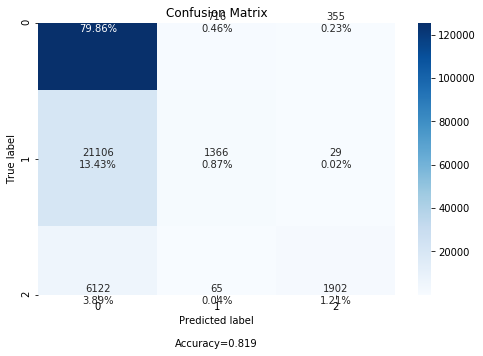

In [123]:
clf_1 = Pipeline([('tfidf', TfidfVectorizer(max_df=0.1, min_df= 0,strip_accents= 'unicode',lowercase=True)),
                 ('NB_clf',MultinomialNB(alpha=0.1))])


clf_1 = clf_1.fit(X_train, y_train)
pred = clf_1.predict(X_test)
pred_proba = clf_1.predict_proba(X_test)
print_results(y_test,pred,pred_proba)

In [124]:
clf_2 = Pipeline([('tfidf', TfidfVectorizer(max_df=0.15, min_df= 1e-05,strip_accents= 'unicode',lowercase=True)),
                      ('clf-SGD', SGDClassifier(loss='hinge', penalty='l2',alpha=0.0001,max_iter=2000))])

clf_2 = clf_2.fit(X=X_train,y=y_train)
pred = clf_2.predict(X_test)
print_metrics(pred,y_test)

Accuracy is 81.58775401137564
Precision is 81.53087588094917
Recall is 81.58775401137564
F1-Score is 74.36754486189021


(81.58775401137564, 81.53087588094917, 81.58775401137564, 74.36754486189021)

Accuracy: 0.83
Area Under The Curve: 0.79
Detail:
              precision    recall  f1-score   support

          -1       0.83      0.98      0.90    126588
           0       0.62      0.17      0.26     22501
           1       0.84      0.26      0.39      8089

    accuracy                           0.83    157178
   macro avg       0.77      0.47      0.52    157178
weighted avg       0.80      0.83      0.78    157178



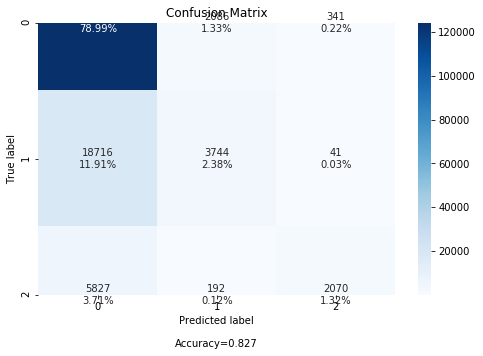

In [140]:
from sklearn.linear_model import LogisticRegression
clf_3 = Pipeline([('tfidf', TfidfVectorizer(max_df=0.15, min_df= 1e-05,strip_accents= 'unicode',lowercase=True)),
                      ('clf-lor', LogisticRegression(solver='newton-cg'))])

clf_3 = clf_3.fit(X=X_train,y=y_train)
pred = clf_3.predict(X_test)
pred_proba = clf_3.predict_proba(X_test)
print_results(y_test,pred,pred_proba)

# Training on Chemtrails Videos

In [141]:
df_chemtrails = pd.read_excel('AllchemtrailsComments.xlsx',index=False).dropna()

#Removing '\n' and '\t' with ' '
df_chemtrails['comment'] =  df_chemtrails['comment'].str.replace('\n',' ')
df_chemtrails['comment'] =  df_chemtrails['comment'].str.replace('\t',' ')


In [142]:

X = df_chemtrails['comment']
Y = df_chemtrails['stance']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=10)
X_train = X_train.reset_index(drop=True).tolist()
X_test  = X_test.reset_index(drop=True).tolist()
y_train = y_train.reset_index(drop=True).tolist()
y_test  = y_test.reset_index(drop=True).tolist()

Accuracy: 0.74
Area Under The Curve: 0.77
Detail:
              precision    recall  f1-score   support

          -1       0.72      0.34      0.46      6699
           0       0.30      0.01      0.02       686
           1       0.74      0.95      0.83     14968

    accuracy                           0.74     22353
   macro avg       0.59      0.43      0.44     22353
weighted avg       0.72      0.74      0.69     22353



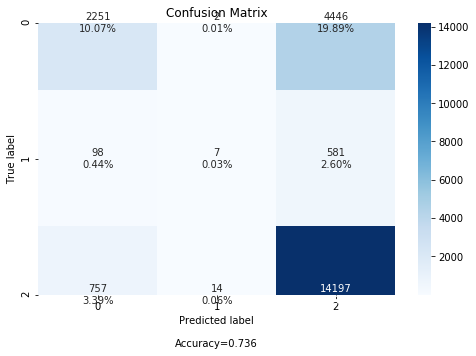

In [143]:
clf_1 = Pipeline([('tfidf', TfidfVectorizer(max_df=0.1, min_df= 0,strip_accents= 'unicode',lowercase=True)),
                 ('NB_clf',MultinomialNB(alpha=0.1))])


clf_1 = clf_1.fit(X_train, y_train)
pred = clf_1.predict(X_test)
pred_proba = clf_1.predict_proba(X_test)
print_results(y_test,pred,pred_proba)

In [144]:
clf_2 = Pipeline([('tfidf', TfidfVectorizer(max_df=0.15, min_df= 1e-05,strip_accents= 'unicode',lowercase=True)),
                      ('clf-SGD', SGDClassifier(loss='hinge', penalty='l2',alpha=0.0001,max_iter=2000))])

clf_2 = clf_2.fit(X=X_train,y=y_train)
pred = clf_2.predict(X_test)
print_metrics(pred,y_test)

Accuracy is 73.3413859437212
Precision is 71.80207040428442
Recall is 75.66345133151798
F1-Score is 68.15850904037445


c:\users\yusuf\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(73.3413859437212, 71.80207040428442, 75.66345133151798, 68.15850904037445)